In [1]:
# Load the Packages

import numpy as np
from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras

### Notation
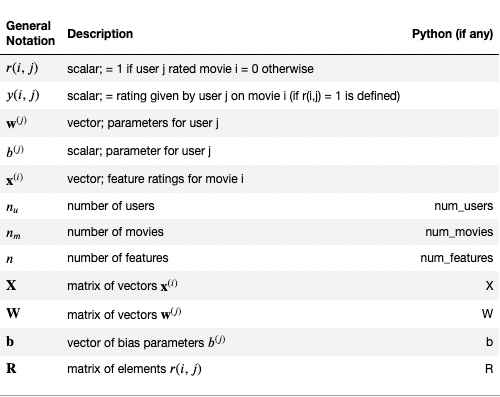

### Recommender Systems
In this lab, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.
The goal of a collaborative filtering recommender system is to generate two vectors: For each user, a 'parameter vector' that embodies the movie tastes of a user. For each movie, a feature vector of the same size which embodies some description of the movie. The dot product of the two vectors plus the bias term should produce an estimate of the rating the user might give to that movie.

The diagram below details how these vectors are learned.
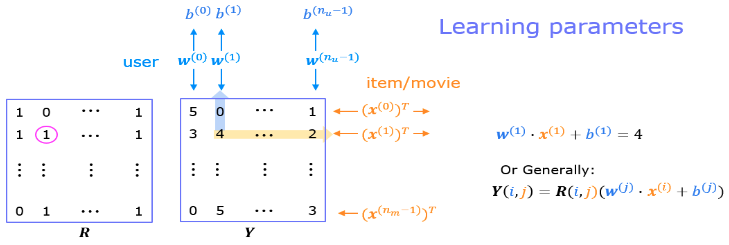

Existing ratings are provided in matrix form as shown. $Y$ contains ratings; 0.5 to 5 inclusive in 0.5 steps. 0 if the movie has not been rated. $R$ has a 1 where movies have been rated. Movies are in rows, users in columns. Each user has a parameter vector $w^{user}$ and bias. Each movie has a feature vector $x^{movie}$. These vectors are simultaneously learned by using the existing user/movie ratings as training data. One training example is shown above: $\mathbf{w}^{(1)} \cdot \mathbf{x}^{(1)} + b^{(1)} = 4$. It is worth noting that the feature vector $x^{movie}$ must satisfy all the users while the user vector $w^{user}$ must satisfy all the movies. This is the source of the name of this approach - all the users collaborate to generate the rating set. 

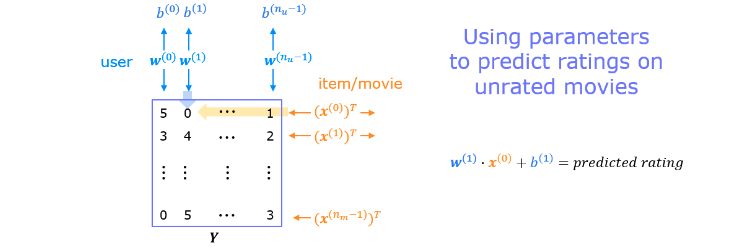

Once the feature vectors and parameters are learned, they can be used to predict how a user might rate an unrated movie. This is shown in the diagram above. The equation is an example of predicting a rating for user one on movie zero.

In this exercise, you will implement the function `cofiCostFunc` that computes the collaborative filtering
objective function. After implementing the objective function, you will use a TensorFlow custom training loop to learn the parameters for collaborative filtering. The first step is to detail the data set and data structures that will be used in the lab.

### Movie Ratings Data Set
The data set is derived from the [MovieLens "ml-latest-small"](https://grouplens.org/datasets/movielens/latest/) dataset.   
[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The original dataset has  9000 movies rated by 600 users. The dataset has been reduced in size to focus on movies from the years since 2000. This dataset consists of ratings on a scale of 0.5 to 5 in 0.5 step increments. The reduced dataset has $n_u = 443$ users, and $n_m= 4778$ movies. 

Below, you will load the movie dataset into the variables $Y$ and $R$.

The matrix $Y$ (a  $n_m \times n_u$ matrix) stores the ratings $y^{(i,j)}$. The matrix $R$ is an binary-valued indicator matrix, where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i,j)=0$ otherwise. 

Throughout this part of the exercise, you will also be working with the
matrices, $\mathbf{X}$, $\mathbf{W}$ and $\mathbf{b}$: 

$$\mathbf{X} = 
\begin{bmatrix}
--- (\mathbf{x}^{(0)})^T --- \\
--- (\mathbf{x}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{x}^{(n_m-1)})^T --- \\
\end{bmatrix} , \quad
\mathbf{W} = 
\begin{bmatrix}
--- (\mathbf{w}^{(0)})^T --- \\
--- (\mathbf{w}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{w}^{(n_u-1)})^T --- \\
\end{bmatrix},\quad
\mathbf{ b} = 
\begin{bmatrix}
 b^{(0)}  \\
 b^{(1)} \\
\vdots \\
b^{(n_u-1)} \\
\end{bmatrix}\quad
$$ 

The $i$-th row of $\mathbf{X}$ corresponds to the
feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of
$\mathbf{W}$ corresponds to one parameter vector $\mathbf{w}^{(j)}$, for the
$j$-th user. Both $x^{(i)}$ and $\mathbf{w}^{(j)}$ are $n$-dimensional
vectors. For the purposes of this exercise, you will use $n=10$, and
therefore, $\mathbf{x}^{(i)}$ and $\mathbf{w}^{(j)}$ have 10 elements.
Correspondingly, $\mathbf{X}$ is a
$n_m \times 10$ matrix and $\mathbf{W}$ is a $n_u \times 10$ matrix.

We will start by loading the movie ratings dataset to understand the structure of the data.
We will load $Y$ and $R$ with the movie dataset.  
We'll also load $\mathbf{X}$, $\mathbf{W}$, and $\mathbf{b}$ with pre-computed values. These values will be learned later in the lab, but we'll use pre-computed values to develop the cost model.

In [2]:
def load_precalc_params_small():

    file = open('./data/small_movies_X.csv', 'rb')
    X = loadtxt(file, delimiter = ",")

    file = open('./data/small_movies_W.csv', 'rb')
    W = loadtxt(file,delimiter = ",")

    file = open('./data/small_movies_b.csv', 'rb')
    b = loadtxt(file,delimiter = ",")
    b = b.reshape(1,-1)
    num_movies, num_features = X.shape
    num_users,_ = W.shape
    return(X, W, b, num_movies, num_features, num_users)
    
def load_ratings_small():
    file = open('./data/small_movies_Y.csv', 'rb')
    Y = loadtxt(file,delimiter = ",")

    file = open('./data/small_movies_R.csv', 'rb')
    R = loadtxt(file,delimiter = ",")
    return(Y,R)

In [3]:
# Load the Data

X, W, b, num_movies, num_features, num_users = load_precalc_params_small()
Y, R = load_ratings_small()

In [4]:
# Inspect the Data

print(f"Shape of Y: {Y.shape}")
print(f"Shape of R: {R.shape}")
print("\n")
print(f"Shape of X: {X.shape}")
print(f"Shape of W: {W.shape}")
print(f"Shape of b: {b.shape}")
print("\n")
print("num_movies (i):",   num_movies)
print("num_users (j):",    num_users)
print("num_features (n):", num_features)

Shape of Y: (4778, 443)
Shape of R: (4778, 443)


Shape of X: (4778, 10)
Shape of W: (443, 10)
Shape of b: (1, 443)


num_movies (i): 4778
num_users (j): 443
num_features (n): 10


In [5]:
print(f"First Row of X:\n {X[0]}\n")
print(f"First Row of W:\n {W[0]}\n")
print(f"First Row of b:\n {b[:,0]}")

First Row of X:
 [-0.03328682  1.1667464  -0.5064895   0.1250965   1.5347596  -0.21013564
  0.10417578 -0.349303    0.75385165 -0.20810875]

First Row of W:
 [ 0.47935075  0.4766997   0.48794055 -0.11980432 -0.32864022  0.4232462
 -0.3951074  -0.2383076  -0.36121953 -0.18090296]

First Row of b:
 [0.23609531]


In [6]:
#  From the Matrix, We Can Compute Statistics like the Average Rating

tsmean =  np.mean(Y[0, R[0, :].astype(bool)])
print(f"Average rating for movie 1 : {tsmean:0.3f} / 5" )

Average rating for movie 1 : 3.400 / 5


### Collaborative Filtering Learning Algorithm
Now, you will begin implementing the collaborative filtering learning
algorithm. You will start by implementing the objective function. 

The collaborative filtering algorithm in the setting of movie
recommendations considers a set of $n$-dimensional parameter vectors
$\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)}$, $\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$ and $b^{(0)},...,b^{(n_u-1)}$, where the
model predicts the rating for movie $i$ by user $j$ as
$y^{(i,j)} = \mathbf{w}^{(j)}\cdot \mathbf{x}^{(i)} + b^{(j)}$ . Given a dataset that consists of
a set of ratings produced by some users on some movies, you wish to
learn the parameter vectors $\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},
\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$  and $b^{(0)},...,b^{(n_u-1)}$ that produce the best fit (minimizes
the squared error).

You will complete the code in cofiCostFunc to compute the cost
function for collaborative filtering. 

#### Collaborative Filtering Cost Function
The collaborative filtering cost function is given by
$$J({\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},\mathbf{w}^{(0)},b^{(0)},...,\mathbf{w}^{(n_u-1)},b^{(n_u-1)}})= \left[ \frac{1}{2}\sum_{(i,j):r(i,j)=1}(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+ \underbrace{\left[
\frac{\lambda}{2}
\sum_{j=0}^{n_u-1}\sum_{k=0}^{n-1}(\mathbf{w}^{(j)}_k)^2
+ \frac{\lambda}{2}\sum_{i=0}^{n_m-1}\sum_{k=0}^{n-1}(\mathbf{x}_k^{(i)})^2
\right]}_{regularization}
\tag{1}$$
The first summation in (1) is "for all $i$, $j$ where $r(i,j)$ equals $1$" and could be written:

$$
= \left[ \frac{1}{2}\sum_{j=0}^{n_u-1} \sum_{i=0}^{n_m-1}r(i,j)*(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+\text{regularization}
$$

You should now write cofiCostFunc (collaborative filtering cost function) to return this cost.

##### For Loop Implementation
Start by implementing the cost function using for loops.
Consider developing the cost function in two steps. First, develop the cost function without regularization. A test case that does not include regularization is provided below to test your implementation. Once that is working, add regularization and run the tests that include regularization.  Note that you should be accumulating the cost for user $j$ and movie $i$ only if $R(i,j) = 1$.

In [7]:
def cofi_cost_func(X, W, b, Y, R, lambda_):
    """
    Returns the cost for collaborative filtering using regularized least squares.
    Args:
      X (ndarray (num_movies,num_features)): Matrix of item features
      W (ndarray (num_users,num_features)) : Matrix of user parameters
      b (ndarray (1, num_users)            : Vector of user parameters
      Y (ndarray (num_movies,num_users)    : Matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : Matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): Regularization parameter
    Returns:
      J (float) : Cost
    """
    nm, nu = Y.shape
    J = 0
    
    for j in range(nu):
        # All Columns of the j-th Row
        w = W[j,:]
        # First Row of the j-th Column
        b_j = b[0,j]
        
        for i in range(nm):
            # All Columns of the i-th Row
            x = X[i,:]
            y = Y[i,j]
            r = R[i,j]
            J += np.square(r * (np.dot(w,x) + b_j - y ) )
    J = J/2

    # Regularization Terms
    n = X.shape[1]
    
    reg_w = 0
    for j in range(nu):
        for k in range(n):
            # Parameter w in the j-th Row, k-th Column
            w_ji = W[j,k]**2
            reg_w += w_ji
            
    reg_w = reg_w * (lambda_/2)
    J += reg_w
    
    reg_x = 0
    for i in range(nm):
        for k in range(n):
            # Feature Value x in the i-th Row, k-th Column
            x_ik = X[i,k]**2
            reg_x += x_ik
            
    reg_x = reg_x * (lambda_/2)
    J += reg_x
    
    return J

In [8]:
# Evalute the Cost Function

# Reduce the Data Set Size So That This Runs Faster
num_users_r = 4
num_movies_r = 5 
num_features_r = 3

X_r = X[:num_movies_r, :num_features_r]
W_r = W[:num_users_r,  :num_features_r]
b_r = b[0, :num_users_r].reshape(1,-1)
Y_r = Y[:num_movies_r, :num_users_r]
R_r = R[:num_movies_r, :num_users_r]


# Without Regularization (Expected Output (lambda = 0): 13.67)
J = cofi_cost_func(X_r, W_r, b_r, Y_r, R_r, 0);
print(f"Cost (w/o Regularization): {J:0.2f}")

# With Regularization (Expected Output (lambda = 1.5): 28.09)
J = cofi_cost_func(X_r, W_r, b_r, Y_r, R_r, 1.5);
print(f"Cost (w/ Regularization): {J:0.2f}")

Cost (w/o Regularization): 13.67
Cost (w/ Regularization): 28.09


##### Vectorized Implementation
It is important to create a vectorized implementation to compute $J$, since it will later be called many times during optimization. The linear algebra utilized is not the focus of this series, so the implementation is provided. If you are an expert in linear algebra, feel free to create your version without referencing the code below. 

Run the code below and verify that it produces the same results as the non-vectorized version.

In [9]:
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for collaborative filtering.
    Vectorized for speed. Uses TensorFlow operations to be compatible with a custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [10]:
# Without Regularization (Expected Output (lambda = 0): 13.67)
J = cofi_cost_func_v(X_r, W_r, b_r, Y_r, R_r, 0);
print(f"Cost (w/o Regularization): {J:0.2f}")

# With Regularization (Expected Output (lambda = 1.5): 28.09)
J = cofi_cost_func_v(X_r, W_r, b_r, Y_r, R_r, 1.5);
print(f"Cost (w/ Regularization): {J:0.2f}")

Cost (w/o Regularization): 13.67
Cost (w/ Regularization): 28.09


2023-08-25 22:36:10.515024: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-25 22:36:10.515048: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-25 22:36:10.515053: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-25 22:36:10.515091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-25 22:36:10.515108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Learning Movie Recommendations
After you have finished implementing the collaborative filtering cost
function, you can start training your algorithm to make
movie recommendations for yourself. 

In the cell below, you can enter your own movie choices. The algorithm will then make recommendations for you! We have filled out some values according to our preferences, but after you have things working with our choices, you should change this to match your tastes.
A list of all movies in the dataset is in the file [movie list](data/small_movie_list.csv).

In [11]:
import pandas as pd

def load_Movie_List_pd():
    """ returns df with and index of movies in the order they are in in the Y matrix """
    df = pd.read_csv('./data/small_movie_list.csv', header=0, index_col=0,  delimiter=',', quotechar='"')
    mlist = df["title"].to_list()
    return(mlist, df)

In [12]:
movieList, movieList_df = load_Movie_List_pd()

# nitialize my_ratings
my_ratings = np.zeros(num_movies)         

# Check the file small_movie_list.csv for id of each movie in our dataset
# For example, Toy Story 3 (2010) has ID 2700, so to rate it "5", you can set
my_ratings[2700] = 5 

#Or suppose you did not enjoy Persuasion (2007), you can set
my_ratings[2609] = 2;

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[929]  = 5   # Lord of the Rings: The Return of the King, The
my_ratings[246]  = 5   # Shrek (2001)
my_ratings[2716] = 3   # Inception
my_ratings[1150] = 5   # Incredibles, The (2004)
my_ratings[382]  = 2   # Amelie (Fabuleux destin d'Amélie Poulain, Le)
my_ratings[366]  = 5   # Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
my_ratings[622]  = 5   # Harry Potter and the Chamber of Secrets (2002)
my_ratings[988]  = 3   # Eternal Sunshine of the Spotless Mind (2004)
my_ratings[2925] = 1   # Louis Theroux: Law & Disorder (2008)
my_ratings[2937] = 1   # Nothing to Declare (Rien à déclarer)
my_ratings[793]  = 5   # Pirates of the Caribbean: The Curse of the Black Pearl (2003)
my_rated = [i for i in range(len(my_ratings)) if my_ratings[i] > 0]

print('\nNew User Ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print(f'Rated {my_ratings[i]} for  {movieList_df.loc[i,"title"]}');


New User Ratings:

Rated 5.0 for  Shrek (2001)
Rated 5.0 for  Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Rated 2.0 for  Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Rated 5.0 for  Harry Potter and the Chamber of Secrets (2002)
Rated 5.0 for  Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Rated 5.0 for  Lord of the Rings: The Return of the King, The (2003)
Rated 3.0 for  Eternal Sunshine of the Spotless Mind (2004)
Rated 5.0 for  Incredibles, The (2004)
Rated 2.0 for  Persuasion (2007)
Rated 5.0 for  Toy Story 3 (2010)
Rated 3.0 for  Inception (2010)
Rated 1.0 for  Louis Theroux: Law & Disorder (2008)
Rated 1.0 for  Nothing to Declare (Rien à déclarer) (2010)


Now, let's add these reviews to $Y$ and $R$ and normalize the ratings.

In [13]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Only include real ratings R(i,j)=1.
    [Ynorm, Ymean] = normalizeRatings(Y, R) normalized Y so that each movie
    has a rating of 0 on average. Unrated moves then have a mean rating (0)
    Returns the mean rating in Ymean.
    """
    Ymean = (np.sum(Y*R,axis=1)/(np.sum(R, axis=1)+1e-12)).reshape(-1,1)
    Ynorm = Y - np.multiply(Ymean, R) 
    return(Ynorm, Ymean)
    
def load_ratings_small():
    file = open('./data/small_movies_Y.csv', 'rb')
    Y = loadtxt(file,delimiter = ",")

    file = open('./data/small_movies_R.csv', 'rb')
    R = loadtxt(file,delimiter = ",")
    return(Y,R)

In [14]:
# Reload ratings
Y, R = load_ratings_small()

# Add new user ratings to Y 
Y = np.c_[my_ratings, Y]

# Add new user indicator matrix to R
R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset
Ynorm, Ymean = normalizeRatings(Y, R)

Let's prepare to train the model. Initialize the parameters and select the Adam optimizer.

In [15]:
#  Useful Values
num_movies, num_users = Y.shape
num_features = 100

# Set Initial Parameters (W, X), use tf.Variable to Track These Variables
# For Consistent Results
tf.random.set_seed(1234)
W = tf.Variable(tf.random.normal((num_users,  num_features),dtype=tf.float64),  name='W')
X = tf.Variable(tf.random.normal((num_movies, num_features),dtype=tf.float64),  name='X')
b = tf.Variable(tf.random.normal((1,          num_users),   dtype=tf.float64),  name='b')

# Instantiate an Optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-1)
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-1)

The operations involved in learning $w$, $b$, and $x$ simultaneously do not fall into the typical 'layers' offered in the TensorFlow neural network package.  Consequently, the flow used in Course 2: Model, Compile(), Fit(), Predict(), are not directly applicable. Instead, we can use a custom training loop.

Recall from earlier labs the steps of gradient descent.
- repeat until convergence:
    - compute forward pass
    - compute the derivatives of the loss relative to parameters
    - update the parameters using the learning rate and the computed derivatives 
    
TensorFlow has the marvelous capability of calculating the derivatives for you. This is shown below. Within the `tf.GradientTape()` section, operations on Tensorflow Variables are tracked. When `tape.gradient()` is later called, it will return the gradient of the loss relative to the tracked variables. The gradients can then be applied to the parameters using an optimizer. 
This is a very brief introduction to a useful feature of TensorFlow and other machine learning frameworks. Further information can be found by investigating "custom training loops" within the framework of interest.

In [16]:
iterations = 200
lambda_ = 1
for iter in range(iterations):
    
    # Use TensorFlow’s GradientTape to Record the Operations Used to Compute the Cost 
    with tf.GradientTape() as tape:

        # Compute the Cost (Forward Pass Included in Cost)
        cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

    # Use the Gradient Tape to Automatically Retrieve the Gradients of the Trainable Variables wrt. the Loss
    grads = tape.gradient(cost_value, [X,W,b])

    # Run One Step of Gradient Descent by Updating the Value of the Variables to Minimize the Loss.
    optimizer.apply_gradients(zip(grads, [X,W,b]))

    # Log Periodically.
    if iter % 20 == 0:
        print(f"Training Loss at Iteration {iter}: {cost_value:0.1f}")

InvalidArgumentError: Cannot assign a device for operation AssignAddVariableOp: Could not satisfy explicit device specification '/job:localhost/replica:0/task:0/device:GPU:0' because no supported kernel for GPU devices is available.
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=1 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignAddVariableOp: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  AssignAddVariableOp (AssignAddVariableOp) /job:localhost/replica:0/task:0/device:GPU:0

Op: AssignAddVariableOp
Node attrs: dtype=DT_DOUBLE
Registered kernels:
  device='XLA_CPU_JIT'; dtype in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, DT_INT8, DT_COMPLEX64, DT_INT64, DT_BFLOAT16, DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]
  device='GPU'; dtype in [DT_FLOAT]
  device='GPU'; dtype in [DT_INT64]
  device='GPU'; dtype in [DT_UINT64]
  device='CPU'; dtype in [DT_UINT64]
  device='CPU'; dtype in [DT_INT64]
  device='CPU'; dtype in [DT_UINT32]
  device='CPU'; dtype in [DT_UINT16]
  device='CPU'; dtype in [DT_INT16]
  device='CPU'; dtype in [DT_UINT8]
  device='CPU'; dtype in [DT_INT8]
  device='CPU'; dtype in [DT_INT32]
  device='CPU'; dtype in [DT_HALF]
  device='CPU'; dtype in [DT_BFLOAT16]
  device='CPU'; dtype in [DT_FLOAT]
  device='CPU'; dtype in [DT_DOUBLE]
  device='CPU'; dtype in [DT_COMPLEX64]
  device='CPU'; dtype in [DT_COMPLEX128]

	 [[{{node AssignAddVariableOp}}]] [Op:AssignAddVariableOp] name: 

In [17]:
# M1 Chip

with tf.device('/CPU:0'):
    tf.random.set_seed(1234)
    W = tf.Variable(tf.random.normal((num_users,  num_features), dtype=tf.float64), name='W')
    X = tf.Variable(tf.random.normal((num_movies, num_features), dtype=tf.float64), name='X')
    b = tf.Variable(tf.random.normal((1,          num_users),    dtype=tf.float64), name='b')
    optimizer = keras.optimizers.Adam(learning_rate=1e-1)

    iterations = 200
    lambda_ = 1
    for iter in range(iterations):
    
        # Use TensorFlow’s GradientTape to Record the Operations Used to Compute the Cost 
        with tf.GradientTape() as tape:

            # Compute the Cost (Forward Pass Included in Cost)
            cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

        # Use the Gradient Tape to Automatically Retrieve the Gradients of the Trainable Variables wrt. the Loss
        grads = tape.gradient(cost_value, [X,W,b])

        # Run One Step of Gradient Descent by Updating the Value of the Variables to Minimize the Loss.
        optimizer.apply_gradients(zip(grads, [X,W,b]))

        # Log Periodically.
        if iter % 20 == 0:
            print(f"Training Loss at Iteration {iter}: {cost_value:0.1f}")

Training Loss at Iteration 0: 2321191.3
Training Loss at Iteration 20: 136169.3
Training Loss at Iteration 40: 51863.7
Training Loss at Iteration 60: 24599.0
Training Loss at Iteration 80: 13630.6
Training Loss at Iteration 100: 8487.7
Training Loss at Iteration 120: 5807.8
Training Loss at Iteration 140: 4311.6
Training Loss at Iteration 160: 3435.3
Training Loss at Iteration 180: 2902.1


### Recommendations
Below, we compute the ratings for all the movies and users and display the movies that are recommended. These are based on the movies and ratings entered as `my_ratings[]` above. To predict the rating of movie $i$ for user $j$, you compute $\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)}$. This can be computed for all ratings using matrix multiplication.

In [18]:
# Make a Prediction Using Trained Weights and Biases
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

# Restore the Mean
pm = p + Ymean

my_predictions = pm[:,0]

# Sort Predictions
ix = tf.argsort(my_predictions, direction='DESCENDING')

for i in range(17):
    j = ix[i]
    if j not in my_rated:
        print(f'Predicting rating {my_predictions[j]:0.2f} for movie {movieList[j]}')

print('\n\nOriginal vs Predicted Ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {movieList[i]}')

Predicting rating 4.49 for movie My Sassy Girl (Yeopgijeogin geunyeo) (2001)
Predicting rating 4.48 for movie Martin Lawrence Live: Runteldat (2002)
Predicting rating 4.48 for movie Memento (2000)
Predicting rating 4.47 for movie Delirium (2014)
Predicting rating 4.47 for movie Laggies (2014)
Predicting rating 4.47 for movie One I Love, The (2014)
Predicting rating 4.46 for movie Particle Fever (2013)
Predicting rating 4.45 for movie Eichmann (2007)
Predicting rating 4.45 for movie Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)
Predicting rating 4.45 for movie Into the Abyss (2011)


Original vs Predicted Ratings:

Original 5.0, Predicted 4.90 for Shrek (2001)
Original 5.0, Predicted 4.84 for Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Original 2.0, Predicted 2.13 for Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Original 5.0, Predicted 4.88 for Harry Potter and the Chamber of Secrets (2002)
Original 5.0, Predic

In practice, additional information can be utilized to enhance our predictions. Above, the predicted ratings for the first few hundred movies lie in a small range. We can augment the above by selecting from those top movies, movies that have high average ratings and movies with more than 20 ratings. This section uses a [Pandas](https://pandas.pydata.org/) data frame which has many handy sorting features.

In [19]:
filter=(movieList_df["number of ratings"] > 20)
movieList_df["pred"] = my_predictions
movieList_df = movieList_df.reindex(columns=["pred", "mean rating", "number of ratings", "title"])
movieList_df.loc[ix[:300]].loc[filter].sort_values("mean rating", ascending=False)

,pred,mean rating,number of ratings,title
1743,4.030961,4.252336,107,"Departed, The (2006)"
2112,3.985281,4.238255,149,"Dark Knight, The (2008)"
211,4.477798,4.122642,159,Memento (2000)
929,4.887054,4.118919,185,"Lord of the Rings: The Return of the King, The..."
2700,4.796531,4.109091,55,Toy Story 3 (2010)
653,4.357304,4.021277,188,"Lord of the Rings: The Two Towers, The (2002)"
1122,4.004471,4.006494,77,Shaun of the Dead (2004)
1841,3.980649,4.000000,61,Hot Fuzz (2007)
3083,4.084643,3.993421,76,"Dark Knight Rises, The (2012)"
2804,4.434171,3.989362,47,Harry Potter and the Deathly Hallows: Part 1 (...
